#Import libraries and data

In [154]:
#Import required Libraries

import numpy as np
import pandas as pd
import scipy

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Linear Models
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

# Data Preprocessing
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Model Selection and Scoring
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_validate, train_test_split
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

blue = '#008FD5'
red = '#FF2700'
green = '#77AB43'

In [155]:
#Import data, Google Colab
import requests
from io import StringIO

#Read files from google drive shared link
def read_csv_gdrive(url):
  file_id = url.split('/')[-2]
  dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
  csv_raw = StringIO(requests.get(dwn_url).text)
  return pd.read_csv(csv_raw)

college = read_csv_gdrive('https://drive.google.com/file/d/1jSQU0BKh58wvKPr0ZutkgdUC4OTkI1tH/view?usp=sharing')
auto = read_csv_gdrive('https://drive.google.com/file/d/10XIhvooZ9I9_0KzBxK-ilEUGUdqhaAyZ/view?usp=sharing')

# Info about College data set

In [156]:
# Rename features
college = college.rename(columns = {'Grad.Rate':'Grad_Rate',
                              'S.F.Ratio': 'Student_Faculty_Ratio',
                              'perc.alumni':'Perc_Alumn_Donate',
                              'Room.Board':'Room_Board',
                              'F.Undergrad':'FT_Undergrad',
                              'P.Undergrad':'PT_Undergrad',
                               'Expend': 'Expend_Per_Student',
                               'Books': 'Cost_Books',
                               'Personal': 'Cost_Personal'})


* College dataset, 777 observation and 18 features

|   Feature   |                 Description                 |
|:-----------:|:-------------------------------------------:|
|   Private   |     "Yes" or "No" to indicate if Private    |
|     Apps    |       Number of applications received       |
|    Accept   |        Number of applicants accepted        |
|   Enroll    |       Number of new students enrolled       |
|  Top10perc  | Pct. new students from top 10% of H.S class |
|  Top25perc  | Pct. new students from top 25% of H.S class |
| FT_Undergrad |     Number of full time undergraduates      |
| PT_Undergrad |      Number of part time undergraduates     |
|   Outstate  |             Out of state tuition            |
|  Room_Board |             Room and Board Costs            |
|     PhD     |          Number of faculty with PhD         |
|   Terminal  |       Pct.Faculty with terminal degree      |
|  Student_Faculty_Ratio  |            Student Faculty Ratio            |
| Perc_Alumn_Donate |            Pct.Alumni that donate           |
|    Expend_Per_Student   |    Instructional expenditure per student    |
|  Grad_Rate  |               Graduation Rate               |
|    Cost_Books    |             Estimated book costs            |
|   Cost_Personal  |           Estimates personal costs          |

In [157]:
college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,FT_Undergrad,PT_Undergrad,Outstate,Room_Board,Cost_Books,Cost_Personal,PhD,Terminal,Student_Faculty_Ratio,Perc_Alumn_Donate,Expend_Per_Student,Grad_Rate,Names
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,Abilene Christian University
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,Adelphi University
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,Adrian College
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,Agnes Scott College
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,Alaska Pacific University


In [158]:
college.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Private                777 non-null    object 
 1   Apps                   777 non-null    int64  
 2   Accept                 777 non-null    int64  
 3   Enroll                 777 non-null    int64  
 4   Top10perc              777 non-null    int64  
 5   Top25perc              777 non-null    int64  
 6   FT_Undergrad           777 non-null    int64  
 7   PT_Undergrad           777 non-null    int64  
 8   Outstate               777 non-null    int64  
 9   Room_Board             777 non-null    int64  
 10  Cost_Books             777 non-null    int64  
 11  Cost_Personal          777 non-null    int64  
 12  PhD                    777 non-null    int64  
 13  Terminal               777 non-null    int64  
 14  Student_Faculty_Ratio  777 non-null    float64
 15  Perc_A

# College Data Analysis - Predict Graduation Rates

### Inspect Response Variable

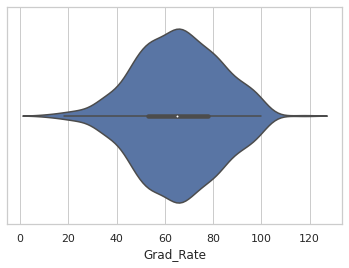

In [159]:
sns.set_theme(style="whitegrid")
sns.violinplot(x=college['Grad_Rate'])

In [160]:
def print_skew(x):
  skew = scipy.stats.skew(x)
  two_se_skew = np.sqrt(6 / x.shape[0]) * 2
  print("Skew = ", skew)
  print("Twice std error of skew = ", two_se_skew)
  if np.abs(skew) > two_se_skew:
    print("Variable skewed. Difference = ", np.abs(skew) - two_se_skew)
  else:
    print("Variable NOT skewed")

print_skew(college['Grad_Rate'])

Skew =  -0.11355752571272018
Twice std error of skew =  0.17574991006549873
Variable NOT skewed


In [161]:
def plot_dist(df, feature, color):
    plt.figure(dpi=80)
    sns.set_theme(style="whitegrid")
    sns.distplot(df[feature], color=color)
    print('''Max value of {} is {}\nMin value of {} is {}\nMean value of {} is {}\nStd value of {} is {}\nMedian value of {} is {}'''
          .format(feature, df[feature].max(),
          feature, df[feature].min(), feature, df[feature].mean(),
          feature, df[feature].std(), feature, df[feature].median()));

Max value of Grad_Rate is 118
Min value of Grad_Rate is 10
Mean value of Grad_Rate is 65.46332046332046
Std value of Grad_Rate is 17.17770989715541
Median value of Grad_Rate is 65.0


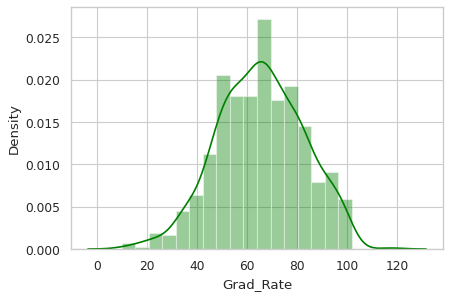

In [162]:
plot_dist(college, 'Grad_Rate', 'GREEN')

The response variable is normally distributed, so there is no need to perform any transformation on it.

There is one outlier that is clearly erroneous (graduation rate > 100).

In [163]:
# Fix outlier
college.at[95, 'Grad_Rate'] = 100

### Explore correlation between predictors and response variable

In [164]:
def corr_heatmap(df):
  corr_matrix = df.corr()
  mask = np.zeros_like(corr_matrix)
  mask[np.triu_indices_from(mask)] = True
  plt.figure(figsize=(15, 9))
  with sns.axes_style("white"):
    sns.set_theme(style="whitegrid")
    sns.heatmap(corr_matrix, annot=True, cmap='PuOr', mask=mask)
    plt.show() # To remove the warning

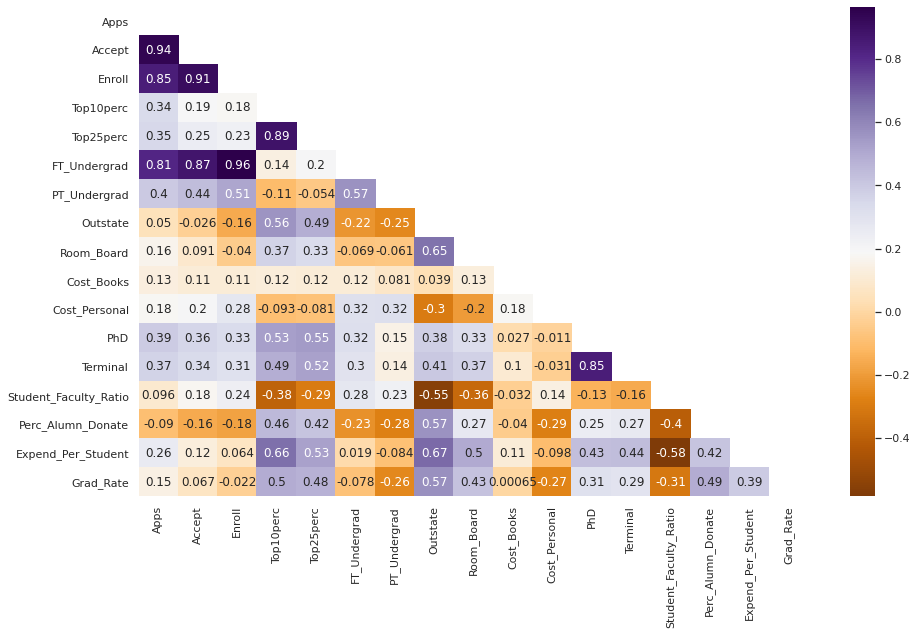

In [165]:
corr_heatmap(college)

Inspect more closely certain features with higher correlation with graduation rate.

Text(0.5, 1.0, 'Outstate Tuition vs Grad Rate')

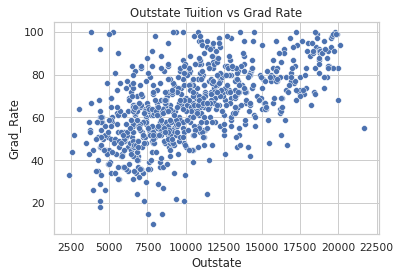

In [166]:
plt.figure(dpi=70)
sns.set_theme(style="whitegrid")
sns.scatterplot(data=college, x="Outstate", y="Grad_Rate")
plt.title("Outstate Tuition vs Grad Rate")

Text(0.5, 1.0, 'Top25perc vs Grad Rate')

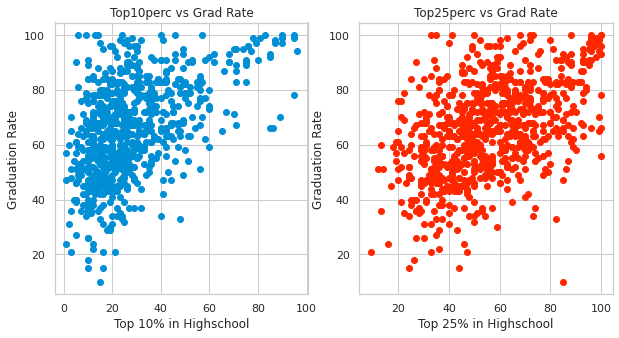

In [167]:
#Relationship between top10.perc, top25.perc and graduation rate
plt.figure(figsize=(10, 5)); 

plt.subplot(1,2,1);
plt.plot(college['Top10perc'],college['Grad_Rate'],'o',color = blue);
plt.xlabel('Top 10% in Highschool');
plt.ylabel('Graduation Rate');
plt.title("Top10perc vs Grad Rate")

plt.subplot(1,2,2);
plt.plot(college['Top25perc'],college['Grad_Rate'],'o',color = red);
plt.xlabel('Top 25% in Highschool');
plt.ylabel('Graduation Rate');
plt.title("Top25perc vs Grad Rate")

Text(0.5, 1.0, 'Perc Alumni vs Grad Rate')

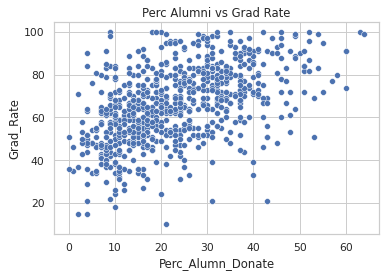

In [168]:
plt.figure(dpi=70)
sns.set_theme(style="whitegrid")
sns.scatterplot(data=college, x="Perc_Alumn_Donate", y="Grad_Rate")
plt.title("Perc Alumni vs Grad Rate")

Text(0.5, 1.0, 'Private vs Grad Rate')

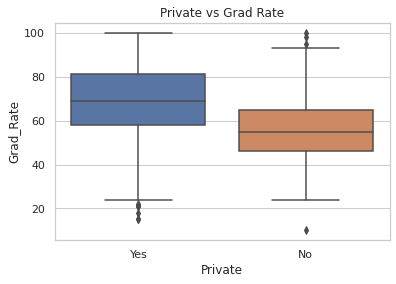

In [169]:
sns.boxplot(x = college['Private'],y = college['Grad_Rate'])
plt.title("Private vs Grad Rate")

### Feature Selection

#### Check for multicolinearity

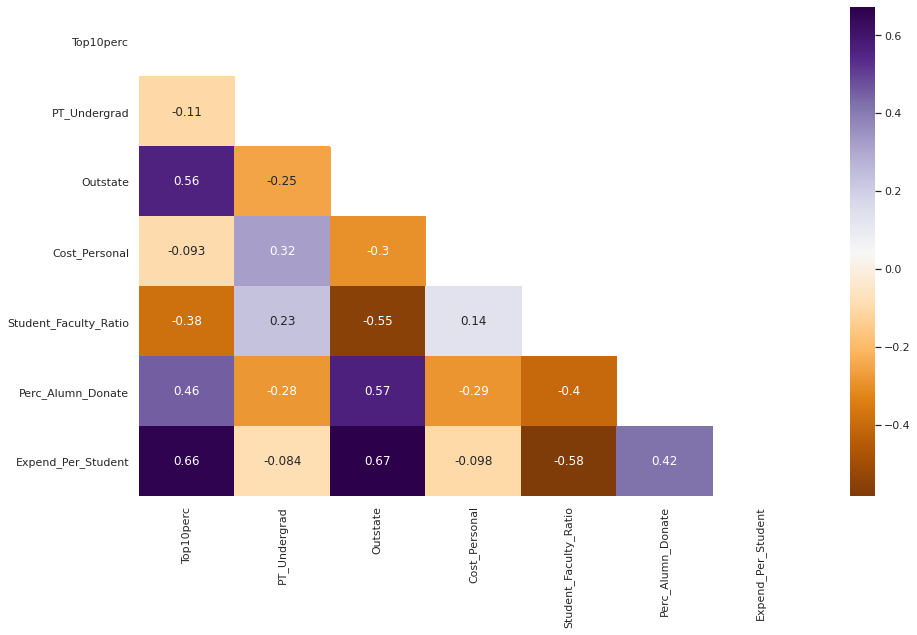

In [170]:
# Only included interesting features
interesting_feats = ['Top10perc', 'PT_Undergrad', 'Outstate', 'Cost_Personal', 'Student_Faculty_Ratio', 'Perc_Alumn_Donate', 'Expend_Per_Student']
corr_heatmap(college[interesting_feats])

Calculate VIF (Variable Inflation Factors) to determine which continuous variables can be determined by other independent variables

In [171]:
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("Total VIF ", np.sum(vif['VIF']))
    return(vif.sort_values(by='VIF', ascending=False))

calc_vif(college[interesting_feats])

Total VIF  53.81836739974873


,variables,VIF
2,Outstate,15.774830
6,Expend_Per_Student,11.147943
5,Perc_Alumn_Donate,6.797711
4,Student_Faculty_Ratio,6.756977
0,Top10perc,6.667296
3,Cost_Personal,5.080798
1,PT_Undergrad,1.592812


In [172]:
calc_vif(college[interesting_feats].drop(labels=['Outstate'], axis=1))

Total VIF  32.23264485928053


,variables,VIF
5,Expend_Per_Student,7.651146
0,Top10perc,6.590179
3,Student_Faculty_Ratio,5.825000
4,Perc_Alumn_Donate,5.524158
2,Cost_Personal,5.072533
1,PT_Undergrad,1.569630


In [173]:
#Remove Outstate because of its high VIF score
interesting_feats.remove('Outstate')

In [174]:
# Add private to interesting feats
interesting_feats += ['Private']

#Modeling

Binarize Private column

In [175]:
college['Private'] = college['Private'].apply(lambda x: 1 if x == 'Yes' else 0)

In [176]:
feats1 = interesting_feats.copy()

### Initial Models

In [177]:
feat_str = 'Grad_Rate~' + '+'.join(feats1)
linreg_model = smf.ols(feat_str, data=college[feats1 + ['Grad_Rate']]).fit()
print(linreg_model.summary())

                            OLS Regression Results                            
Dep. Variable:              Grad_Rate   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     67.00
Date:                Mon, 04 Jan 2021   Prob (F-statistic):           2.41e-75
Time:                        18:29:14   Log-Likelihood:                -3123.8
No. Observations:                 777   AIC:                             6264.
Df Residuals:                     769   BIC:                             6301.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                47.13

Appears that there is high multicolinearity. Let's look into this further

In [178]:
calc_vif(college[feats1])

Total VIF  39.114680890563385


,variables,VIF
5,Expend_Per_Student,8.305007
0,Top10perc,6.671515
4,Perc_Alumn_Donate,6.509278
3,Student_Faculty_Ratio,6.134122
2,Cost_Personal,5.085687
6,Private,4.656380
1,PT_Undergrad,1.752691


The addition of Private has changed the VIF scores. Will remove 'Expend_Per_Student' beccause it has the highest VIF and lowest t-statistic

In [179]:
calc_vif(college[feats1].drop('Expend_Per_Student', axis=1))

Total VIF  27.434784393675862


,variables,VIF
4,Perc_Alumn_Donate,6.257395
3,Student_Faculty_Ratio,6.054401
2,Cost_Personal,4.917862
5,Private,4.289779
0,Top10perc,4.204453
1,PT_Undergrad,1.710894


The removal of 'Expend_Per_Student' has dropped the overall VIF scores. Albiet still high, we will refit the model. 

In [180]:
feats2 = ['Top10perc',
 'PT_Undergrad',
 'Cost_Personal',
 'Student_Faculty_Ratio',
 'Perc_Alumn_Donate',
 'Private']

In [181]:
feat_str = 'Grad_Rate~' + '+'.join(feats2)
linreg_model2 = smf.ols(feat_str, data=college[feats2 + ['Grad_Rate']]).fit()
print(linreg_model2.summary())

                            OLS Regression Results                            
Dep. Variable:              Grad_Rate   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     78.06
Date:                Mon, 04 Jan 2021   Prob (F-statistic):           3.87e-76
Time:                        18:29:14   Log-Likelihood:                -3124.2
No. Observations:                 777   AIC:                             6262.
Df Residuals:                     770   BIC:                             6295.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                48.67

We get similar accuracy with one less predictor. Again we have some ill-conditioning happening due to multicollinearity. Let's remove 'Student_Faculty_Ratio' for the same reason we removed the previous feature.

In [182]:
calc_vif(college[feats2].drop('Student_Faculty_Ratio', axis=1))

Total VIF  19.145919429590858


,variables,VIF
3,Perc_Alumn_Donate,5.925708
0,Top10perc,4.204453
4,Private,4.114963
2,Cost_Personal,3.283887
1,PT_Undergrad,1.616908


Refit the model without 'Perc_Alumn_Donate' since it had the highest VIF score. Cannot rely on the coefficients since the design matrix is still ill-conditioned.

In [183]:
feats3 = ['Top10perc',
 'PT_Undergrad',
 'Cost_Personal',
 'Perc_Alumn_Donate',
 'Private']

In [184]:
feat_str = 'Grad_Rate~' + '+'.join(feats3)
linreg_model3 = smf.ols(feat_str, data=college[feats3 + ['Grad_Rate']]).fit()
print(linreg_model3.summary())

                            OLS Regression Results                            
Dep. Variable:              Grad_Rate   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     93.74
Date:                Mon, 04 Jan 2021   Prob (F-statistic):           4.08e-77
Time:                        18:29:14   Log-Likelihood:                -3124.3
No. Observations:                 777   AIC:                             6261.
Df Residuals:                     771   BIC:                             6289.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            49.7814      1.89

Again, similar accuracy obtained while removing one predictor. Let's try once more to remove another predictor since we still have ill-conditioning. 

In [185]:
feats4 = ['Top10perc', 'Cost_Personal', 'Perc_Alumn_Donate', 'Private']

In [186]:
feat_str = 'Grad_Rate~' + '+'.join(feats4)
linreg_model4 = smf.ols(feat_str, data=college[feats4 + ['Grad_Rate']]).fit()
print(linreg_model4.summary())

                            OLS Regression Results                            
Dep. Variable:              Grad_Rate   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     115.7
Date:                Mon, 04 Jan 2021   Prob (F-statistic):           2.55e-77
Time:                        18:29:14   Log-Likelihood:                -3126.3
No. Observations:                 777   AIC:                             6263.
Df Residuals:                     772   BIC:                             6286.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            48.7559      1.83

### Cross Validation and Model Tuning

As we removed features with low coefficient accuracy/reliability and also reduced multi-colinearity, we see that the R2 score was also decreasing so we'll cross validate on a few different set of features

In [187]:
feature_sets = [feats1, feats2, feats3, feats4]

Code to cross validate model with different set of features

In [188]:
# Helper function to calculate adjusted R2 score
def calc_adj_r2(r2, n, p):
  return 1-(1-r2)*((n-1)/(n-p-1))

# Helper function to print report of regression accuracy scores
def accuracy_df(scores):
  mean_scores = {}
  mean_scores['R2'] = np.mean(scores['test_r2'])
  mean_scores['Adjusted R2'] =  np.mean(scores['test_r2'])
  mean_scores['MSE'] =  -1*np.mean(scores['test_neg_mean_squared_error'])
  mean_scores['RMSE'] =  -1*np.mean(scores['test_neg_root_mean_squared_error'])
  return pd.DataFrame(mean_scores.values(), columns=['Score'], index=mean_scores.keys())

# Cross validate model and print report on model accuracy
def cross_val_accuracy(X, y, model, folds):
  scores = cross_validate(model, X, y, scoring=['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error'], cv=folds)
  adj_r2 = [calc_adj_r2(r2, X.shape[0], X.shape[1]) for r2 in scores['test_r2']]
  scores['test_adj_r2'] = adj_r2
  return accuracy_df(scores)

Code to build model pipelines

In [189]:
def pipe_feat_transformers(list_transformers):
  # Create pipeline of transformers (similar to make_pipeline)
  transformer_tuples = []
  for t in list_transformers:
    t_name = str(t).split('(')[0] #name of transformer
    transformer_tuples.append((t_name, t))
  return Pipeline(transformer_tuples)

def final_pipe(preprocessor, model):
  # Combine Column Transformer and model into final pipeline
  model_name = str(model).split('(')[0]
  steps = [('preprocessor', preprocessor), (model_name, model)]
  return Pipeline(steps)

def pipe_transforms_with_model(transform_dicts, model):
  # pipline for each unique set of feature transforms
  feature_transform_pipes = [pipe_feat_transformers(transform_dict['transforms']) for transform_dict in transform_dicts]
  
  # Create list of transformer pipeline tuples to pass into ColumnTransformer
  transformers_param = []
  for transform, ft_pipe in zip(transform_dicts, feature_transform_pipes):
    transformers_param.append((transform['name'], ft_pipe, transform['features']))
  
  preprocessor = ColumnTransformer(transformers=transformers_param, remainder='passthrough', n_jobs=-1)
  return final_pipe(preprocessor, model)

For each feature set, run 10 fold cross validation and print model accuracy

In [195]:
for feat_set in feature_sets:
  transform_dicts = [{
      'name': 'numeric_transforms', 
      'transforms': [PowerTransformer()], 
      'features': [x for x in feat_set if x != 'Private']
  }]

  pipe = pipe_transforms_with_model(transform_dicts, LinearRegression())
  print("Features: ", feat_set)
  print(cross_val_accuracy(college[feat_set], college['Grad_Rate'], pipe, 10))
  print('\n')

Features:  ['Top10perc', 'PT_Undergrad', 'Cost_Personal', 'Student_Faculty_Ratio', 'Perc_Alumn_Donate', 'Expend_Per_Student', 'Private']
                  Score
R2             0.335168
Adjusted R2    0.335168
MSE          187.291417
RMSE          13.662589


Features:  ['Top10perc', 'PT_Undergrad', 'Cost_Personal', 'Student_Faculty_Ratio', 'Perc_Alumn_Donate', 'Private']
                  Score
R2             0.336054
Adjusted R2    0.336054
MSE          186.911568
RMSE          13.649281


Features:  ['Top10perc', 'PT_Undergrad', 'Cost_Personal', 'Perc_Alumn_Donate', 'Private']
                  Score
R2             0.338037
Adjusted R2    0.338037
MSE          186.358061
RMSE          13.629249


Features:  ['Top10perc', 'Cost_Personal', 'Perc_Alumn_Donate', 'Private']
                  Score
R2             0.338226
Adjusted R2    0.338226
MSE          186.303027
RMSE          13.625185




### Model Evaluation

All models perform similarly and are not very predictive overall, but we will assess the validity of the results with a residual plot and QQ plot

In [191]:
X_train, X_test, y_train, y_test = train_test_split(college[feats4], college['Grad_Rate'], test_size=0.33, shuffle=True, random_state=42)

best_model = pipe_transforms_with_model(transform_dicts, LinearRegression()).fit(X_train, y_train)
y_hat = best_model.predict(X_test)

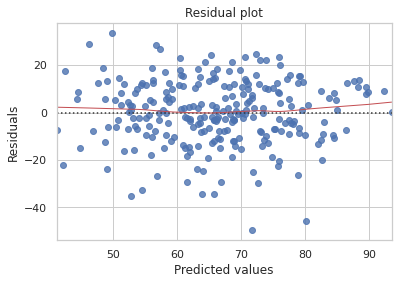

In [192]:
sns.set_theme(style='whitegrid')
sns.residplot(y_hat, y_test, lowess=True, line_kws={'color':'r', 'lw':1})
plt.title('Residual plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

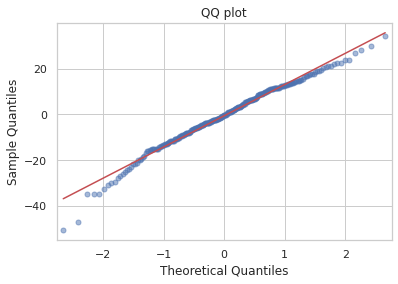

In [193]:
ProbPlot(y_test - y_hat).qqplot(alpha=0.5, markersize=5, line='s')
plt.title('QQ plot')
plt.show()

By in large, the residual plot shows randomness and the QQ plot shows that the residuals are normally distributed. If I had more time, I would investigate some of the slightly outlier data points. 